<a href="https://colab.research.google.com/github/the-real-dezhi/Arduino-Android-Sensors/blob/master/handwriting3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 Preprocessing Stage**
The preprocessing of the dataset is one of the most important and time-consuming steps of any deep learning project. Most of the time, we have a dataset that is not well-processed and ready to be fed into a neural network. Sometimes, the data might even be clean and organized, but not suitable to fit to our problem.

In this scenario, we have a dataset of Persian handwritten digits and we want to recognize digits only by looking at their image. Here is a brief stat of our dataset:


In [0]:
# Download the dataset and unzip
! wget -q http://iust-deep-learning.github.io/972/static_files/assignments/asg01_assets/data.zip
! unzip data.zip -d .

Archive:  data.zip
  inflating: ./test.cdb              
  inflating: ./train.cdb             
  inflating: ./util.py               


 we have to import some prerequisites:

In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,9) # Make the figures a bit bigger
import cv2
from keras.utils import to_categorical

from util import read_raw_dataset

Using TensorFlow backend.


Let's load the dataset using the provided function read_raw_dataset:



In [0]:

ds_images, ds_labels = read_raw_dataset("train.cdb")

print("Images:")
print(type(ds_images))
print(len(ds_images))
print(type(ds_images[0]))
print(ds_images[0].shape)

print("\nLabels:")
print(ds_labels[:30])

Images:
<class 'list'>
60000
<class 'numpy.ndarray'>
(27, 20)

Labels:
[6, 5, 0, 2, 7, 0, 7, 5, 0, 7, 0, 6, 3, 6, 5, 5, 3, 3, 2, 9, 6, 3, 4, 4, 0, 7, 2, 7, 8, 6]


As you can see, train_images is a list of images and train_labels contains the labels for each element in the image list. Each image is represented as 2D (numpy) array of floats/ints.

So, lets look at some of the images:

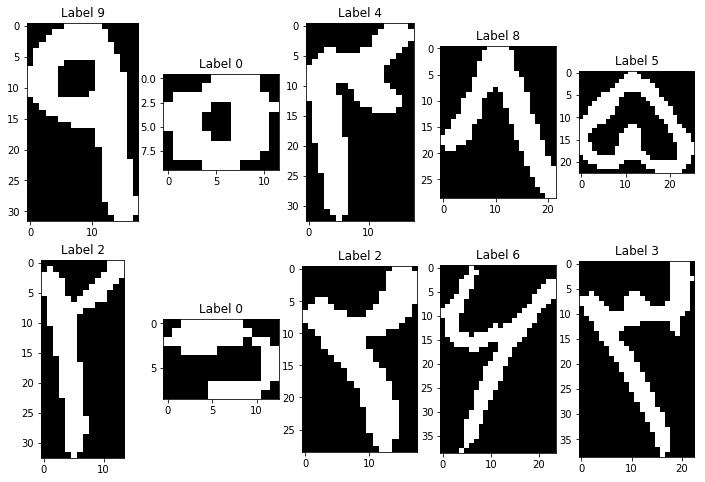

In [0]:
# Randomly sample images, Re run the cell to see new images.
plt.figure(figsize=(12,8))
for i, index in enumerate(random.sample(list(range(len(ds_images))), 10)):
    plt.subplot(2,5,i+1)
    plt.imshow(ds_images[index], cmap='gray', interpolation='none')
    plt.title("Label {}".format(ds_labels[index]))

Pretty great! ha? But it seems images are not in a fixed dimension. Let's check our hypothesis:



In [0]:
unique_heights = list(set([m.shape[0] for m in ds_images]))
print("unique heights:", unique_heights)

unique_widths = list(set([m.shape[1] for m in ds_images]))
print("unique widths:", unique_widths)

unique heights: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
unique widths: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51]


Unfortunately, the images in our dataset do not have equal dimensions. So, we have to implement a function to fit the image in a fixed frame.

Note: There might be a situation where the image is bigger than the frame size; So, we first need to scale it down and then fit it into a fixed frame.

In [0]:
def fit_and_resize_image(src_image, dst_image_size):

  dst_image_height = 32
  dst_image_width = dst_image_height
    
  src_image_height = src_image.shape[0]
  src_image_width = src_image.shape[1]

  if src_image_height > dst_image_height or src_image_width > dst_image_width:
      height_scale = dst_image_height / src_image_height
      width_scale = dst_image_width / src_image_width
      scale = min(height_scale, width_scale)
      img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
  else:
      img = src_image

  img_height = img.shape[0]
  img_width = img.shape[1]

  dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

  y_offset = (dst_image_height - img_height) // 2
  x_offset = (dst_image_width - img_width) // 2

  dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

  return dst_image

In [0]:
# Define a constant for our image size.
IMAGE_SIZE = 32

Text(0.5, 1.0, 'After')

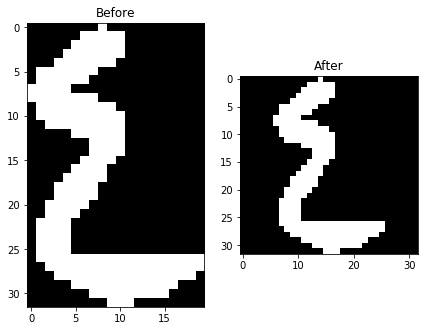

In [0]:
plt.subplot(1,2,1); plt.imshow(ds_images[72], cmap='gray', interpolation='none'); plt.title('Before')
plt.subplot(1,2,2); plt.imshow(fit_and_resize_image(ds_images[72], IMAGE_SIZE), cmap='gray', interpolation='none'); plt.title('After')

 Now it's time to use that and create a function to read the dataset, process it, and return it as a Numpy array. As you may have noticed, image values are in the 0-255 range (0 is black and 255 is white). Generally, we first normalize our input when we want to feed them into a neural network. So, don't forget to normalize the images.

Note: When we're solving a multi-label classification probelm it is important for the labels to be in one-hot format. So we need to convert them to one-hot format before returning the function.

In [0]:
def read_dataset(dataset_path, images_size=32):
  
  """
  Read & process Persian handwritten digits dataset
  
  Args:
    dataset_path: path to dataset file
    image_size: size that should be fixed for all images.
    
  Returns:
    X: numpy ndarry with shape (num_samples, images_size, images_size) for normalized images 
    y: numpy ndarry with shape (num_samples, 10) for labels in one-hot format
  """
  
  images, labels = read_raw_dataset(dataset_path)

  X = np.zeros(shape=[len(images), images_size, images_size], dtype=np.float32)

  for i, img in enumerate(images):
    X[i] = fit_and_resize_image(img, IMAGE_SIZE) / 255.0
  
  Y = to_categorical(labels, num_classes=10, dtype=np.int)
  
  return X, Y


**Why should we normalize images to the [0-1] range?**
Normalizing inputs make them have similar scales. This property will lead to a symmetric cost function, which is easier and faster to optimize.

Great! Now we have everything ready to build our neural network.



In [0]:
train_images, train_labels = read_dataset("train.cdb", IMAGE_SIZE)
test_images, test_labels = read_dataset("test.cdb", IMAGE_SIZE)

assert train_images.shape == (60000, IMAGE_SIZE, IMAGE_SIZE)
assert test_images.shape == (20000, IMAGE_SIZE, IMAGE_SIZE)

assert train_labels.shape == (60000, 10)
assert test_labels.shape == (20000, 10)

assert train_images.mean() > 0.0
assert test_images.mean() > 0.0

assert 0. <= train_images.min() and train_images.max() <= 1
assert 0. <= test_images.min() and test_images.max() <= 1

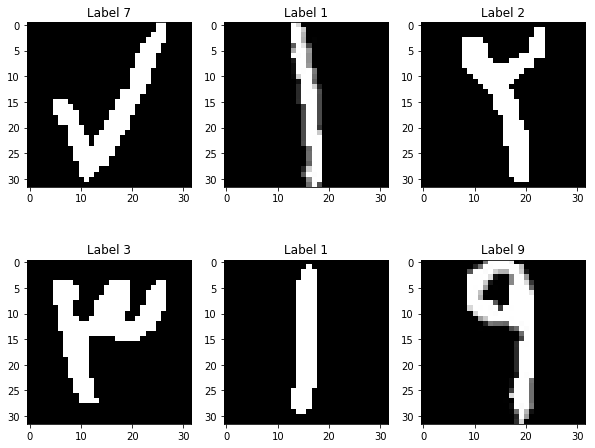

In [0]:
plt.figure(figsize=(10,8))
for i, index in enumerate(random.sample(list(range(len(train_images))), 6)):
    plt.subplot(2,3,i+1)
    plt.imshow(train_images[index], cmap='gray', interpolation='none')
    plt.title("Label {}".format(str(np.argmax(train_labels[index]))))

# **2 Building the model**

In class, we exclusively used Keras Layers API to build a neural network; but, now, we want to get a little deeper and see what's going on behind this API.

## **2.1 Low level implementation**
When we code in Keras, we are simply stacking up layer instances. However the implementation of neural networks is basically nothing but matrix multiplication and applying functions on them. Deep learning libraries are made to perform matrix multiplication in the first place; so, each of these frameworks should be equipped with matrix manipulation tools and APIs. Keras is no exception.

Perhaps you might think that Keras library has much higher level abstractions which makes significantly easier to work with. So, why do we have to learn low-level APIs? The point is that there are situations that we need low-level APIs. For example:



*   Sometimes the layers we want to use are not included in the default Keras implementation thus we have to implement them by ourselves.

*   More importantly, other deep learning frameworks such as Tensorflow and Pytorch are more commonly used in low-level mode. Learning such APIs will enable us to better understand the source codes of papers and existing projects available on the Internet.



Before starting to code, let's review some of the mathematics behind neural networks. We store connection's weights between layers in the shape of a matrix. Also, we represent layer bais as a matrix too. Here is an example:
![alt text](https://github.com/the-real-dezhi/deep-farsi/blob/master/nn_weight.jpg)

Suppose we have two layers in a neural network. Let  x∈R(N×1)  be the activations of the previous layer with  N  nodes,  W  be the weight of connections and  B be the bais for the current layer. Write an algebraic equation for the current layer with  M  nodes and activations  h . Also, specify dimensions of matrices  W,B,h :
![alt text](https://github.com/the-real-dezhi/deep-farsi/blob/master/2019-07-07_14-18-53.png)

Please note that Broadcasting is used to calculate the sum of  WT.x  and  B 

But, computers, especially GPUs, are much more efficient in parallel computing. So, instead of feeding single input  x→  through our neural network, why not feed them a batch? Thus, the input vector  x→∈RN×1  will be a matrix in the shape of  Rb×N  ( b  is the batch size) and each individual input will be one of  x  rows.

Rewritre equation for  h  above and specify the dimensions of matrices  W,B,h 

![alt text](https://github.com/the-real-dezhi/deep-farsi/blob/master/2019-07-07_14-19-09.png)

Please note that Broadcasting is used to calculate the sum of  x.W  and  B

In [0]:
from keras import backend as K
from keras.layers import Layer, Dense, Dropout
from keras.models import Sequential
from keras.utils.layer_utils import count_params

from util import BaseModel

Here is the model class that we're going to implement. LowLevelMLP is a simple MLP network with a configurable number of hidden layers. To complete this section you need to fill its two methods __init__() and build_model(). We use  __init__ to define networks weights and build_model() to specify operations between input and model weights to create the output.


In [0]:
#model configuration
HIDDEN_LAYERS = [512, 128]
NUM_CLASSES = 10
NUM_EPOCH = 20
BATCH_SIZE = 512

In [0]:
class LowLevelMLP(BaseModel):
  
  def __init__(self, input_shape, hidden_layers, num_classes=10):
    """
    Initiate model with provided configuration
    Args:
      input_shape: size of input vector
      hidden_layers: a list of integer, specify num hidden layer node from left to right,
                     e.x.: [512, 128, ...]
      num_classes: an integer defining number of classes, this is the number of model ouput nodes
    """
    super(LowLevelMLP, self).__init__()
    
    self._input_shape = input_shape
    self._hidden_layers = hidden_layers
    self._num_classes = num_classes
    
    # Define model weights & biases according to self.hidden_layers and self.num_classes 
    # To create weight you can use self.add_weight
    
    self._model_weights = []
    self._model_baiases = []

    last_input_size = input_shape
    for h in self._hidden_layers + [num_classes]:
      self._model_weights.append(self.add_weight(
          name='hid_%s' % h, 
          shape=(last_input_size, h), 
          initializer='glorot_uniform'
      ))
      self._model_baiases.append(self.add_weight(
          name='bias_%s' % h, 
          shape=(h, ), 
          initializer='zeros'
      ))

      last_input_size = h
    
    
  def build_model(self, x):
    """
    The Model logic sits here.
    Args:
      x: an input tensor in shape of (?, input_size), ? is batch size and will be determined at the training phase
         e.x.: x is tensor with shape (?, 784) for the MNIST dataset

    Returns:
      pred: an output tensor with shape (?, self.num_classes)

    """

    h = x

    for w, b in zip(self._model_weights, self._model_baiases):
      h = K.relu(K.dot(h, w) + b)

    pred = K.softmax(h)

    return pred
    

ll_mlp = LowLevelMLP(IMAGE_SIZE ** 2, HIDDEN_LAYERS, NUM_CLASSES)
ll_mlp._model_weights, ll_mlp._model_baiases

W0709 17:10:02.130039 139738805720960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 17:10:02.171862 139738805720960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



([<tf.Variable 'hid_512:0' shape=(1024, 512) dtype=float32_ref>,
  <tf.Variable 'hid_128:0' shape=(512, 128) dtype=float32_ref>,
  <tf.Variable 'hid_10:0' shape=(128, 10) dtype=float32_ref>],
 [<tf.Variable 'bias_512:0' shape=(512,) dtype=float32_ref>,
  <tf.Variable 'bias_128:0' shape=(128,) dtype=float32_ref>,
  <tf.Variable 'bias_10:0' shape=(10,) dtype=float32_ref>])

In [0]:
assert  count_params(ll_mlp.trainable_weights) == sum(
    [(i*j) for i, j in zip([IMAGE_SIZE ** 2] + HIDDEN_LAYERS, HIDDEN_LAYERS + [NUM_CLASSES])] 
    + HIDDEN_LAYERS 
    + [NUM_CLASSES]
)

In [0]:
# Before start training the model, we need to reshape the input so that each 32x32 image
# becomes a single 1024 dimensional vector.

x_train = train_images.reshape((-1, IMAGE_SIZE * IMAGE_SIZE))
y_train = train_labels.astype('float32')

x_test = test_images.reshape((-1, IMAGE_SIZE * IMAGE_SIZE))
y_test = test_labels.astype('float32')

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(60000, 1024) (20000, 1024)
(60000, 10) (20000, 10)


In [0]:
ll_mlp.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
ll_mlp_history = ll_mlp.fit(x_train, y_train, epochs=NUM_EPOCH, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

W0709 17:11:17.608830 139738805720960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0709 17:11:17.626014 139738805720960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 17:11:17.650423 139738805720960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0709 17:11:17.756893 139738805720960 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.

Train on 60000 samples, validate on 20000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 79us/step - loss: 1.0461 - acc: 0.5746 - val_loss: 1.0219 - val_acc: 0.5764
Epoch 2/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.9495 - acc: 0.5945 - val_loss: 0.9753 - val_acc: 0.5903
Epoch 3/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.9361 - acc: 0.5969 - val_loss: 0.9938 - val_acc: 0.5877
Epoch 4/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.9308 - acc: 0.5981 - val_loss: 0.9742 - val_acc: 0.5908
Epoch 5/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.9273 - acc: 0.5986 - val_loss: 0.9641 - val_acc: 0.5915
Epoch 6/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.9261 - acc: 0.5987 - val_loss: 0.9599 - val_acc: 0.5937
Epoch 7/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.9250 - acc: 0.5989 - val_loss: 0.9669 - val_acc

Now visualize the traning:



In [0]:
def visualize_loss_and_acc(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc = history_dict['acc']

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  acc_values = history_dict['acc']
  val_acc = history_dict['val_acc']

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

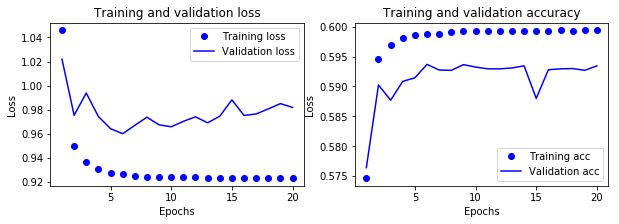

In [0]:
visualize_loss_and_acc(ll_mlp_history)


In [0]:
#save weights of our network
ll_mlp.save_weights('ll_mlp.h5')

## **2.2 Custom Layer: Softmax**
In this section, we're going to implement A custom Keras layer, A much realistic situation. For the sake of simplicity, we want to re-implement Softmax Layer. Before going through softmax implementation, let's review some of softmax details:

Softmax has an interesting property that is quite useful in practice, Softmax is invariant to constant offsets in the input, that is, for any input vector  x  and any constant  c 

softmax(x)=softmax(x+c)

where  x+c  means adding the constant c to every dimension of  x . we had that:

softmax(x)[i]=ex[i]/∑[(j)] ex[j]

In practice, we make use of this property and choose  c=−max[i] x[i]  when computing softmax probabilities for numerical stability (i.e., subtracting its maximum element from all elements of  x ).

In [0]:
class Softmax2D(Layer):
  """
  Softmax activation function, Only works for 2d arrays.
  """

  def __init__(self, **kwargs):
    super(Softmax2D, self).__init__(**kwargs)
    # We don't have any configuration for this custom layer,
    # But in future you should save any configuration related 
    # to your layer in its constructor
    
  def compute_output_shape(self, input_shape):
    """Computes the output shape of the layer.

    Assumes that the layer will be built
    to match that input shape provided.

    Args:
      input_shape: Shape tuple (tuple of integers)
        or list of shape tuples (one per output tensor of the layer).
        Shape tuples can include None for free dimensions,
        instead of an integer.

    Returns:
      An input shape tuple.
    """
    # softmax of course doesn't change input shape, 
    # so we can simply return input_shape as output shape
    return input_shape 
  
  def build(self, input_shape):
    """
    This is where you will define your weights. 
    This method must set self.built = True at the end, 
    which can be done by calling super(Softmax2D, self).build().
    
    Args:
      input_shape: Keras tensor (future input to layer)
        or list/tuple of Keras tensors to reference
        for weight shape computations.
    """
    # As softmax is simple activation layer, we don't need any weight  
    # definitions for this layer.
    super(Softmax2D, self).build(input_shape)
    
  def call(self, x):
    """
    This is where the layer's logic lives.
    
    Args:
      x: Input tensor, or list/tuple of input tensors.
      
    Returns:
      A tensor.
    """
    orig_shape = x.shape
    
    x = x - K.max(x, axis=1, keepdims=True)
    x = K.exp(x)
    sum_vec = K.sum(x, axis=1, keepdims=True)
    x = x / sum_vec
    
    assert x.shape[1] == orig_shape[1] and len(x.shape) == len(orig_shape)
    return x

In [0]:
x = K.constant(np.array([[1001, 1002], [3, 4]]))
test2 = K.eval(Softmax2D()(x))
print(test2)
ans2 = np.array([
  [0.26894142, 0.73105858],
  [0.26894142, 0.73105858]])
assert np.allclose(test2, ans2, rtol=1e-05, atol=1e-06)
print("Passed!")

[[0.26894143 0.7310586 ]
 [0.26894143 0.7310586 ]]
Passed!


How to use our custom layer in practice?



In [0]:
# Create simple MLP network similar to what you implmented in previous section
s2d_mlp = Sequential()
s2d_mlp.add(Dense(512, activation='relu'))
s2d_mlp.add(Dense(128, activation='relu'))
s2d_mlp.add(Dense(NUM_CLASSES, activation=None))
s2d_mlp.add(Softmax2D()) # This is your custom layer, 

# compile & train model
s2d_mlp.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
s2d_history = s2d_mlp.fit(
    x_train, y_train, 
    epochs=NUM_EPOCH, 
    batch_size=BATCH_SIZE, 
    validation_data=(x_test, y_test)
)

Train on 60000 samples, validate on 20000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.2049 - acc: 0.9385 - val_loss: 0.1707 - val_acc: 0.9461
Epoch 2/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.0596 - acc: 0.9823 - val_loss: 0.1605 - val_acc: 0.9464
Epoch 3/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.0345 - acc: 0.9894 - val_loss: 0.0839 - val_acc: 0.9749
Epoch 4/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.0217 - acc: 0.9931 - val_loss: 0.1382 - val_acc: 0.9624
Epoch 5/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.0154 - acc: 0.9951 - val_loss: 0.0784 - val_acc: 0.9787
Epoch 6/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.0098 - acc: 0.9968 - val_loss: 0.1225 - val_acc: 0.9694
Epoch 7/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.0071 - acc: 0.9978 - val_loss: 0.1091 - val_acc

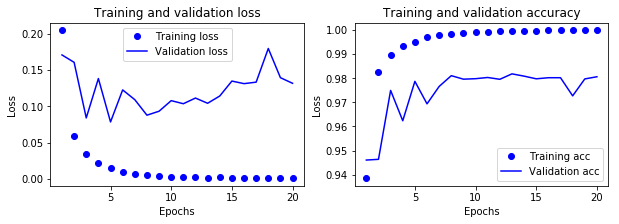

In [0]:
visualize_loss_and_acc(s2d_history)


In [0]:
s2d_mlp.save(str('s2d_mlp.h5'))


# **3 Dropout**
As you see, the validation error of the model starts to grow around epoch 5. But, our network is being optimized on the training loss during this time and its error is continuously reduced if the training dataset is not big enough (which is the case here). The model has mastered the task on the training set, but the learned network doesn't generalize to new examples that it has never seen!

Dropout is one of the most common regularization techniques used to prevent overfitting. It randomly shuts down some neurons in each iteration.

The reasons that why Dropout helps model generalization (not overfitting) is :


1.   Not all connections between neurons are really necessary! by using dropout we zero down some of them (in each iteration), forcing our model to learn data with less number of connections (or neurons) leading to a simpler model with higher generalization power.
2.   On the other hand, changing dropped neurons in each iteration makes our models an implicit ensemble of simpler neural networks, each learned the data in a different way. so we have many simple and diverse models which is expected to be better in generalization
3.   Also we can interpret dropout as adding noise in output layer of each layer. this can break up insignificant patterns that occur in each layer, which our network would tend to memorize in training without dropout.

[Thanks to my friend Mohsen Tabassy for explaining these reasons]



In [0]:
ss_mlp = Sequential()
ss_mlp.add(Dense(16, activation='relu', input_shape=(1024,)))
ss_mlp.add(Dense(16, activation='relu'))
ss_mlp.add(Dense(10, activation='sigmoid'))

ss_mlp.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

ss_mlp_history = ss_mlp.fit(x_train, 
                                y_train, 
                                epochs=20, 
                                batch_size=512,
                            validation_data=(x_test, y_test))

print("Accuracy on Test set is:", ss_mlp.evaluate(x_test, y_test)[1])

Train on 60000 samples, validate on 20000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 13us/step - loss: 0.2123 - acc: 0.9274 - val_loss: 0.1190 - val_acc: 0.9578
Epoch 2/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.0580 - acc: 0.9830 - val_loss: 0.0802 - val_acc: 0.9732
Epoch 3/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.0400 - acc: 0.9883 - val_loss: 0.0651 - val_acc: 0.9789
Epoch 4/20
60000/60000 [==============================] - 1s 9us/step - loss: 0.0328 - acc: 0.9906 - val_loss: 0.0573 - val_acc: 0.9823
Epoch 5/20
60000/60000 [==============================] - 1s 9us/step - loss: 0.0287 - acc: 0.9919 - val_loss: 0.0525 - val_acc: 0.9841
Epoch 6/20
60000/60000 [==============================] - 1s 9us/step - loss: 0.0260 - acc: 0.9926 - val_loss: 0.0487 - val_acc: 0.9853
Epoch 7/20
60000/60000 [==============================] - 1s 9us/step - loss: 0.0240 - acc: 0.9931 - val_loss: 0.0475 - val_acc: 0.

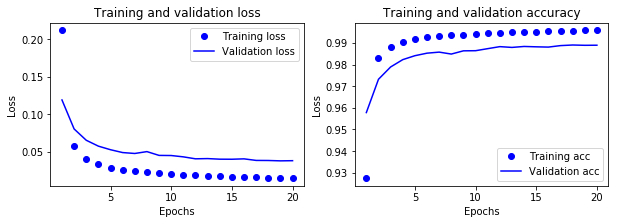

In [0]:
visualize_loss_and_acc(ss_mlp_history)


As you can see, The model is overfitting quite fast! In this section you have to change the model, its prameters, and maybe add new layers to improve overfitting!

In [0]:
ss_imprv = Sequential()

ss_imprv.add(Dense(16, activation='relu'))
ss_imprv.add(Dropout(0.5))                         # hidden layer dropout
ss_imprv.add(Dense(16, activation='relu'))         
ss_imprv.add(Dropout(0.5))                         # hidden layer dropout
ss_imprv.add(Dense(10, activation='sigmoid'))

ss_imprv.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

ss_imprv_history = ss_imprv.fit(x_train, 
                                y_train, 
                                epochs=20, 
                                batch_size=512, 
                                validation_data=(x_test, y_test))

print("Accuracy on Test set is:", ss_imprv.evaluate(x_test, y_test)[1])

W0709 17:13:44.230825 139738805720960 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 60000 samples, validate on 20000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.4981 - acc: 0.7681 - val_loss: 0.2981 - val_acc: 0.9086
Epoch 2/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.3448 - acc: 0.8742 - val_loss: 0.2043 - val_acc: 0.9236
Epoch 3/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.2780 - acc: 0.9013 - val_loss: 0.1612 - val_acc: 0.9327
Epoch 4/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.2449 - acc: 0.9114 - val_loss: 0.1372 - val_acc: 0.9482
Epoch 5/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.2233 - acc: 0.9179 - val_loss: 0.1245 - val_acc: 0.9543
Epoch 6/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.2088 - acc: 0.9222 - val_loss: 0.1174 - val_acc: 0.9557
Epoch 7/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.2017 - acc: 0.9245 - val_loss: 0.1121 - val_acc

Improves model:

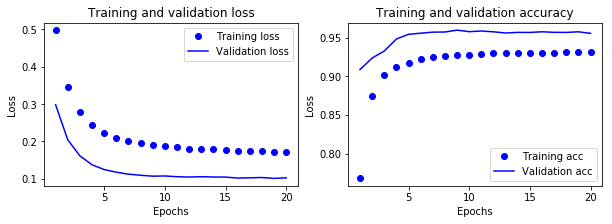

In [0]:
visualize_loss_and_acc(ss_imprv_history)

Base model:

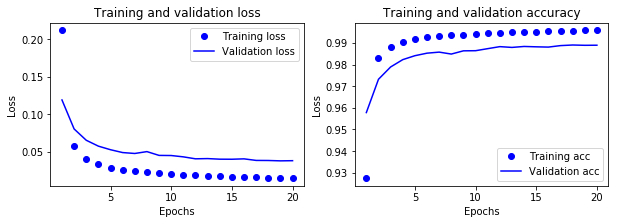

In [0]:
visualize_loss_and_acc(ss_mlp_history)


In [0]:
ss_imprv.save(str('imdb_imprv.h5'))

# **batch normalization**

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Layer, Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

In [0]:
class BatchNormalizedLayer(Layer):
  def __init__(self, layer, axis=-1, activation=None, **kwargs):
    """Runs batch normalization on layer instance and applies the activation function
    
    Args:
      layer(layers.Layer): A layer to normalize its output
      axis(int): the axis that should be normalized (typically the features axis).
      activation(str): Activation function to use
    """
    super(BatchNormalizedLayer, self).__init__(**kwargs)
    
    self.layer = layer
    self.activation = activation
    self.axis = axis
    
    self.batch_norm = BatchNormalization(axis=self.axis)
    self.act_fn = Activation(self.activation)
    
  def compute_output_shape(self, input_shape):
    return self.layer.compute_output_shape(input_shape)
    
  def call(self, inputs, training=None):

    x = self.layer(inputs)
    x = self.batch_norm(x, training=training)
    x = self.act_fn(x)
    
    self.trainable_weights += self.layer.trainable_weights + self.batch_norm.trainable_weights
    self.non_trainable_weights += self.layer.non_trainable_weights + self.batch_norm.non_trainable_weights
    
    return x

In [0]:
import numpy as np

bnl = BatchNormalizedLayer(Dense(5), activation='relu')
x = K.constant(2.5 * np.random.randn(10, 4) + 3)

assert K.eval(bnl(x)).shape == (10, 5)

# **CNN**

Now we have our special layer. So, let's use it in a real neural network. We want to improve the baseline using the Batch Normalization layer. Our desired task is farsi_handwritten_numbers image classification.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

num_classes = 10

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# fig, axes1 = plt.subplots(2,5,figsize=(10,4))
# for j in range(2):
#   for k in range(5):
#     i = np.random.choice(range(len(x_train)))
#     axes1[j][k].set_axis_off()
#     axes1[j][k].imshow(x_train[i:i+1][0])
        
# Normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (60000, 1024)
60000 train samples
20000 test samples


In [0]:
def visualize_loss_and_acc(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc = history_dict['acc']

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  acc_values = history_dict['acc']
  val_acc = history_dict['val_acc']

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

define the baseline model

In [0]:
x_train.shape

(60000, 1024)

In [0]:
def get_baseline_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.rmsprop(lr=0.0001, decay=1e-6),
                metrics=['accuracy'])
  
  return model

create baseline model

In [0]:
batch_size = 32
epochs = 25

In [0]:
# Create the baseline model
baseline = get_baseline_model()

# Train model
bs_history = baseline.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True
)

ValueError: ignored

visualizing model

In [0]:
visualize_loss_and_acc(bs_history)


In [0]:
# Score trained model.
scores = baseline.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])